<a href="https://colab.research.google.com/github/jobsiggang/2026_AI_Datascience/blob/main/2026_%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1%ED%9A%8C%EA%B7%80_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#타이타닉 탑승자 데이터를 기반으로 생존자 예측하는 모델 생성

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **[데이터 로딩]**

In [ ]:
titanic_df = pd.read_csv('/content/drive/MyDrive/2025data/titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### **[데이터 확인 및 전처리]**

In [ ]:
# 기본 요약 정보
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# titanic_df.Cabin.value_counts()
titanic_df['Cabin'].value_counts()

,count
Cabin,
G6,4
C23 C25 C27,4
B96 B98,4
F2,3
D,3
...,...
E17,1
A24,1
C50,1


In [ ]:
# 머신러닝 모델은 NULL을 허용하지 않으므로 결측치 처리 수행 - 대체값
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('N')
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('N')
print('NULL 갯수 : \n', titanic_df.isnull().sum())

NULL 갯수 : 
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [ ]:
# Cabin 컬럼의 분포 확인
titanic_df.Cabin.value_counts()

,count
Cabin,
N,687
G6,4
C23 C25 C27,4
B96 B98,4
F2,3
...,...
E17,1
A24,1
C50,1


In [ ]:
# Cabin Category를 크게 정리
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]

titanic_df.Cabin.value_counts()

,count
Cabin,
N,687
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


### **[모델의 학습 전 데이터 탐색]**

* 어떤 유형의 승객이 생존확률이 더 높았을지 확인 (가설)


    1. 여성 또는 노약자 먼저 구한다.

    2. 부자 또는 유명인

    3. 삼등실 승객들


In [ ]:
# 성별에 따른 생존 결과 확인 (0 : 사망, 1 : 생존)
#여성 중 생존한 그룹, 여성 중 사망한 그룹, 남성 중 생존한 그룹, 남성 중 사망한 그룹.
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

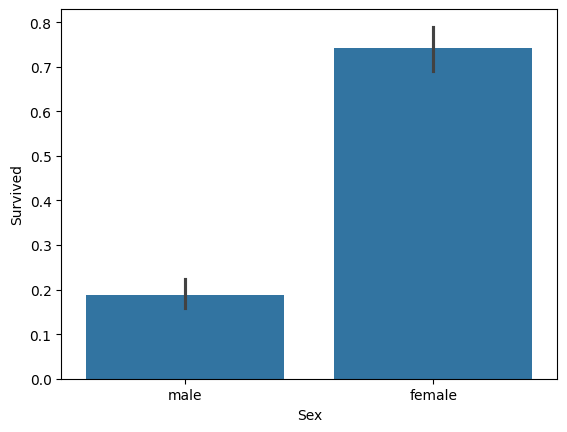

In [ ]:
# 더 명확하게 확인하고 싶으면 시각화를 통해서 체크
#여성 생존률 = 생존한 여성 수 / 전체 여성 수
#barplot이란?
#**막대그래프(bar chart)**를 그리는 Seaborn 함수.
#x축이나 y축에 범주형 데이터를 두고, 다른 축에 수치형 데이터를 두면, 해당 범주별로 평균값 또는 통계치를 막대 높이로 표현해줌.
sns.barplot(x='Sex', y='Survived', data=titanic_df)
plt.show()                               # 1 가설 중 여성이 상대적으로 더 많이 생존

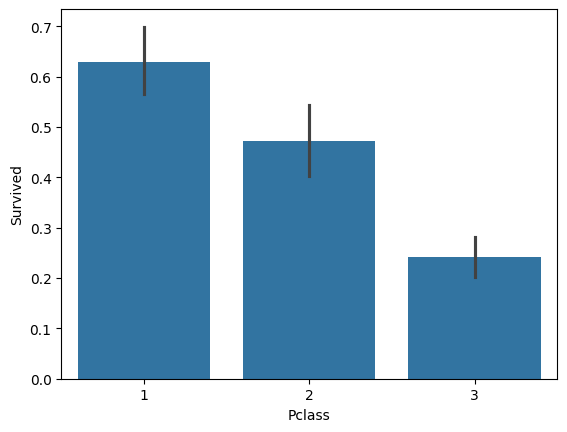

In [ ]:
# 부자 또는 유명인의 생존 결과 확인
sns.barplot(x='Pclass', y='Survived', data=titanic_df)
plt.show()                   # 2, 3 가설 확인

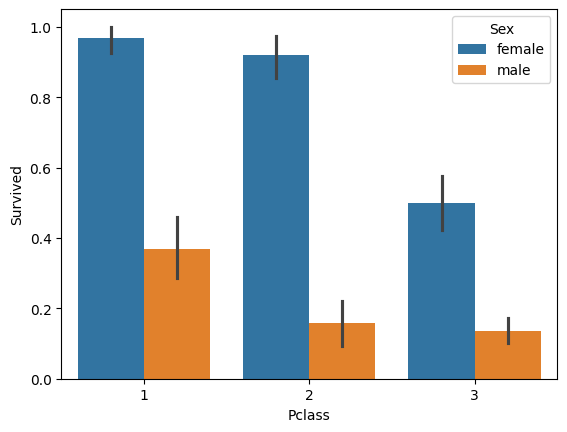

In [ ]:
# 부자 또는 유명인의, 그리고 성별에 따른 생존 결과 확인
#hue='Sex' → 성별로 나누어서 색상(막대)을 구분
#등급이 높을수록 생존률이 올라가고, 여성일수록 생존률이 높음

sns.barplot(x='Pclass', y='Survived', data=titanic_df, hue='Sex')
plt.show()

In [ ]:
# 1) 1 가설 중 노약자에 대한 확인이 필요
#   Age 컬럼은 연속된 숫자값 형태 (continous) -> 범위별로 구별되도록 처리
def get_category(age):
  category = ''
  if age <= -1 : category = 'Unknown'
  elif age <= 5 : category = 'Baby'
  elif age <= 12 : category = 'Child'
  elif age <= 18 : category = 'Teenager'
  elif age <= 25 : category = 'Student'
  elif age <= 35 : category = 'Young Adult'
  elif age <= 60 : category = 'Adult'
  else : category = 'Elderly'
  return category

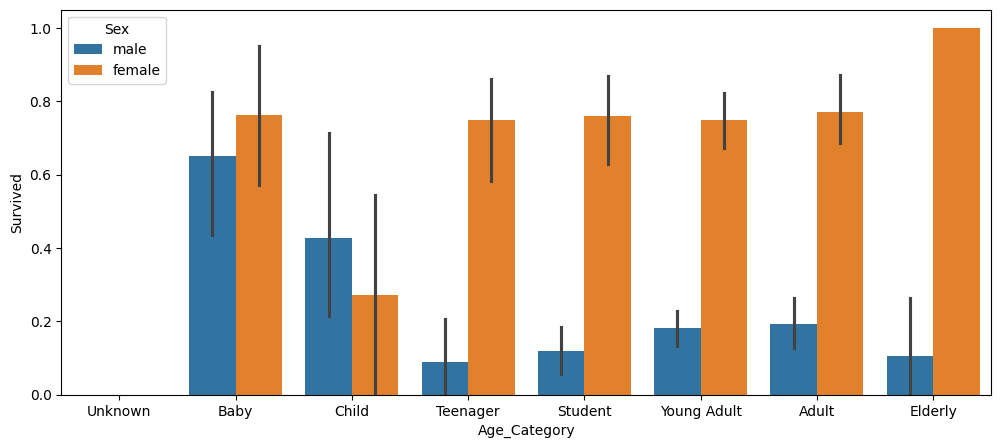

In [ ]:
category_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

titanic_df['Age_Category'] = titanic_df['Age'].apply(lambda x : get_category(x))

plt.figure(figsize=(12, 5))

sns.barplot(x='Age_Category', y='Survived', hue='Sex', data=titanic_df, order=category_names)
plt.show()

In [ ]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S,Young Adult


In [ ]:
titanic_df.drop('Age_Category', axis=1, inplace=True)

titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# [모델 생성 , 학습, 평가]

In [ ]:
# 📦 데이터 로딩
import pandas as pd
titanic_df = pd.read_csv('/content/drive/MyDrive/2025data/titanic.csv')  # CSV 파일에서 데이터 불러오기
# 🧼홍길동 결측치 처리
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('N')
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('N')

# 🔢 범주형 변수 원-핫 인코딩 (Sex, Embarked)
# drop_first=True 옵션은 더미 변수 함정 방지를 위해 첫 번째 범주는 제거함
titanic_df = pd.get_dummies(titanic_df, columns=['Sex', 'Embarked'], drop_first=True)
print(titanic_df.columns)

# 🎯 타겟 데이터 (생존 여부) 분리
y_titanic = titanic_df['Survived']  # 머신러닝에서 예측할 라벨

# 🧠 특징(feature) 데이터 선택
X_titanic = titanic_df[[ 'PassengerId','Pclass', 'Age', 'SibSp', 'Parch', 'Embarked_N', 'Embarked_Q',
       'Embarked_S', 'Sex_male'
         ]] #홍길동

# 👀 선택된 feature 데이터 미리 보기
X_titanic.head()


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Sex_male', 'Embarked_N', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


,PassengerId,Pclass,Age,SibSp,Parch,Embarked_N,Embarked_Q,Embarked_S,Sex_male
0,1,3,22.0,1,0,False,False,True,True
1,2,1,38.0,1,0,False,False,False,False
2,3,3,26.0,0,0,False,False,True,False
3,4,1,35.0,1,0,False,False,True,False
4,5,3,35.0,0,0,False,False,True,True


In [ ]:
X_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Embarked_N   891 non-null    bool   
 6   Embarked_Q   891 non-null    bool   
 7   Embarked_S   891 non-null    bool   
 8   Sex_male     891 non-null    bool   
dtypes: bool(4), float64(1), int64(4)
memory usage: 38.4 KB


### **[모델 생성 , 학습, 평가]**

In [ ]:
# 📦 필요한 라이브러리 임포트
from sklearn.model_selection import train_test_split                    # 학습/테스트 데이터 분리
from sklearn.tree import DecisionTreeClassifier                        # 결정 트리 모델
from sklearn.ensemble import RandomForestClassifier                    # 랜덤 포레스트 모델
from sklearn.linear_model import LogisticRegression                    # 로지스틱 회귀 모델
from sklearn.metrics import accuracy_score                             # 정확도 평가 함수

# 📊 학습 세트와 테스트 세트 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X_titanic, y_titanic, test_size=0.2, random_state=11)

# 🤖 모델 객체 생성
dt_cf = DecisionTreeClassifier(random_state=11)        # 결정 트리
rf_cf = RandomForestClassifier(random_state=11)        # 랜덤 포레스트
lr_crf = LogisticRegression(solver='liblinear', random_state=11)  # 로지스틱 회귀

# ✅ 결정 트리 모델 학습 및 예측
dt_cf.fit(X_train, y_train)
dt_cf_pred = dt_cf.predict(X_test)
print(f'결정트리 모델의 정확도 : {accuracy_score(y_test, dt_cf_pred)}')

# ✅ 랜덤 포레스트 모델 학습 및 예측
rf_cf.fit(X_train, y_train)
rf_cf_pred = rf_cf.predict(X_test)
print(f'랜덤포레스트 모델의 정확도 : {accuracy_score(y_test, rf_cf_pred)}')

# ✅ 로지스틱 회귀 모델 학습 및 예측
lr_crf.fit(X_train, y_train)
lr_crf_pred = lr_crf.predict(X_test)
print(f'로지스틱 회귀 모델의 정확도 : {accuracy_score(y_test, lr_crf_pred)}')


결정트리 모델의 정확도 : 0.7430167597765364
랜덤포레스트 모델의 정확도 : 0.8212290502793296
로지스틱 회귀 모델의 정확도 : 0.8491620111731844


In [ ]:
sample = pd.DataFrame([{
    'PassengerId': 892,
    'Pclass': 3,
    'Age': 34.5,
    'SibSp': 0,           # 형제/배우자 없음
    # 'Sex_male': 1,       # 남성이므로 1
    'Parch': 0,           # 부모/자녀 없음
    'Embarked_N': 0,     # 'Q'이므로 나머지는 0
    'Embarked_Q': 1,     # 탑승항이 'Q' (Queenstown)
    'Embarked_S': 0,
    'Sex_male': 1
}])


In [ ]:
pred=lr_crf.predict(sample)
print(f'예측 결과 : {pred}')
print(f'예측 확률 : {lr_crf.predict_proba(sample)}')

예측 결과 : [0]
예측 확률 : [[0.84081399 0.15918601]]
